In [1]:
from Flower import *

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [ ]:
train_data = DataHandler(path=data_path, prefix="", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5,)# return_idx=True)
test_data = DataHandler(path=data_path, prefix="", load_to_ram=False,
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0,) # return_idx=True)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2,drop_last=True,)

In [2]:
# initialize probability class

prior_ranges = {
    "astro_params": {
        "L_X": [38, 42],
        "NU_X_THRESH": [100, 1500],
        "ION_Tvir_MIN": [4, 5.3],
        "HII_EFF_FACTOR": [10, 250]
    }
}

fiducial_parameter = {
    "user_params": {
        "HII_DIM": 40,
        "BOX_LEN": 160,
        "N_THREADS": 1,
        "USE_INTERPOLATION_TABLES": True,
    },
    "flag_options": {
        "USE_TS_FLUCT": False,
        "INHOMO_RECO": False
    },
    "astro_params": {
        "INHOMO_RECO": False,
        "L_X": 40,
        "NU_X_THRESH": 500,
        "ION_Tvir_MIN": 5,
        "HII_EFF_FACTOR": 30
    },
    "make_statistics": False,
}

probability = Probability(prior_ranges=prior_ranges, z_chunks=10, bins=10, debug=True, 
                          fmodel_path="./emcee_data/fiducial_ps.npy")

emcee = Flower(Probability=probability, redshift=5, data_path="./emcee_data/", noise_type=None,
                       regenerate_fiducial=True, fid_params=fiducial_parameter, debug=True)

emcee.make_fiducial()


emcee.run_emcee(threads=2, nsteps=240, walkers=24)


Set initial parameters...
initialize Simulation class...
Search for existing fiducial lightcone...
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 30
    ION_Tvir_MIN    : 100000
    L_X             : 10000000000000000000000000000000000000000
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 500
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 15.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 100000
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.30964144154550644
   

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Current parameters are:{'astro_params': {'L_X': 39.080854686128355, 'NU_X_THRESH': 883.9461917936009, 'ION_Tvir_MIN': 4.046277668552544, 'HII_EFF_FACTOR': 105.00323989816408}}
Prior is 1
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 105.00323989816408
    ION_Tvir_MIN    : 11124.427463152024
    L_X             : 1.2046328057405684e+39
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 883.9461917936009
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 15.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 11124.427463152024
    t_STAR  

In [ ]:
{'global_params': {'M_WDM': 3.501515617898722}, 
 'cosmo_params': {'OMm': 0.14078494774504743}, 
 'astro_params': {'L_X': 2.093953125940754, 
                  'NU_X_THRESH': 453.94456146918685, 
                  'ION_Tvir_MIN': 0.25907883271173016, 
                  'HII_EFF_FACTOR': 192.22061520453673}}

In [1]:
from powerbox import get_power
import numpy as np
data = np.random.rand(100,100,100)
from matplotlib import pyplot as plt

ps, k, var = get_power(data, boxlength=100, bin_ave=True, get_variance=True, ignore_zero_mode=True)

In [115]:
#field = lightcone.brightness_temp[:,:,zbins[bin]:zbins[bin+1]]
import py21cmfast as p21c
lightcone = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
field = lightcone.brightness_temp[:,:, 1100:1400]
boxlength = lightcone.cell_size*np.asarray(lightcone.brightness_temp[:,:500:800].shape)

ps_perp,k_perp, var_perp,_ = get_power(field, boxlength=boxlength, res_ndim=2, bins = 10, 
                        ignore_zero_mode=True, bin_ave=True, get_variance=True) 
ps_par, k_par, var_par,_ = get_power(field.T, boxlength=boxlength, res_ndim=1, bins = 10, 
                            ignore_zero_mode=True, bin_ave=True, get_variance=True)
ps_perp = np.mean(ps_perp,axis=1)
var_perp = np.mean(var_perp, axis=1)
var_par = np.mean(var_par, axis=1)
ps_par = np.mean(ps_par, axis=(1,2))
ps = np.outer(ps_perp, ps_par)
ps_var = np.sqrt(np.outer(var_perp, var_par))

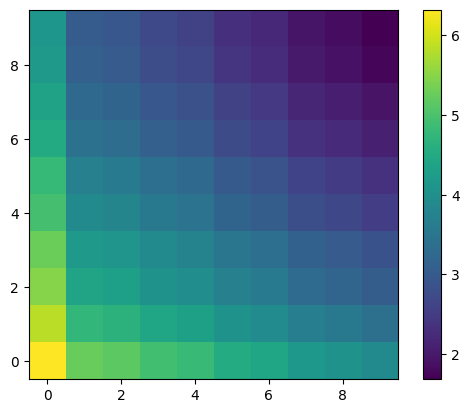

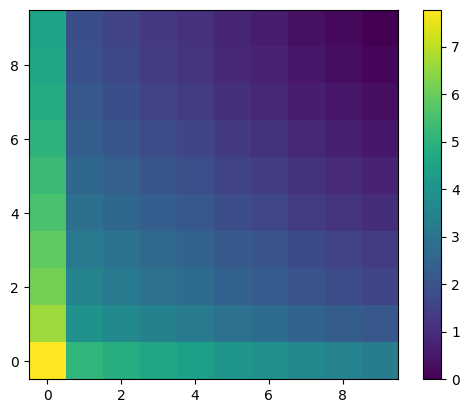

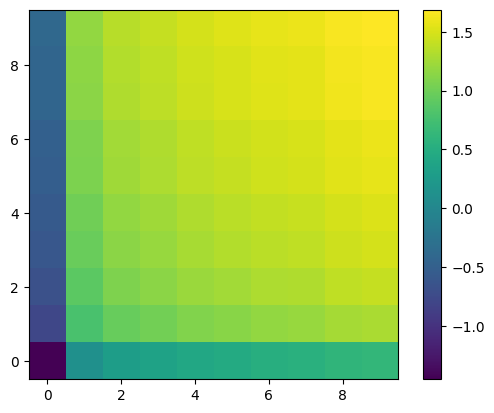

In [116]:
plt.imshow(np.log10(ps), origin='lower')
plt.colorbar()  
plt.show()
plt.imshow(np.log10(ps_var), origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np.log10(ps/ps_var), origin='lower')
plt.colorbar()
plt.show()

In [99]:
field.shape

(110, 110, 300)

In [65]:
ps_var = np.outer(var_perp_*k_perp**2, var_par_*k_par).T

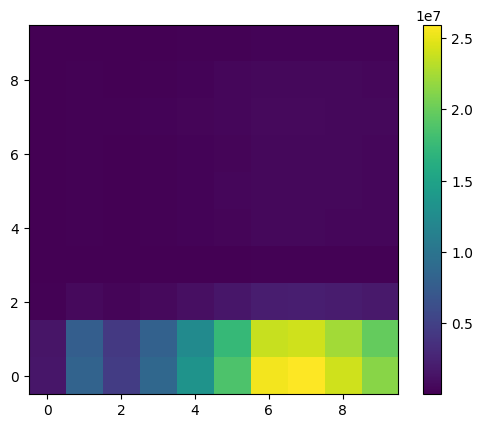

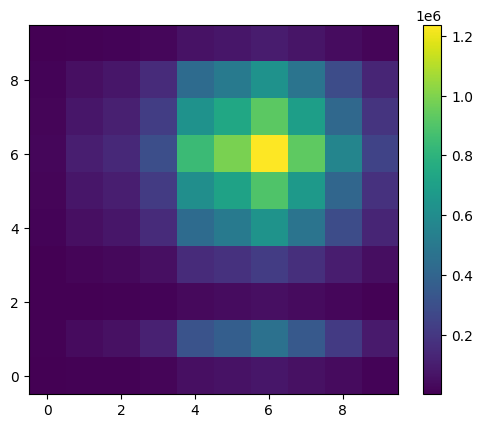

In [66]:
plt.imshow(ps, origin='lower')
plt.colorbar()  
plt.show()
plt.imshow(ps_var, origin='lower')
plt.colorbar()
plt.show()